In [1]:
import pandas as pd
import numpy as np# linear algebra
from numpy import nan
from numpy import array
#from mpl_toolkits.mplot3d import Axes3D
#from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import os # accessing directory structure


In [2]:
#already dropped NA's
#sorted entries by date
dataset = pd.read_csv('venice_new.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])

print(dataset.tail())

                       wh  temp
datetime                       
2020-10-01 23:20:00  0.51  10.6
2020-10-01 23:30:00  0.51  10.5
2020-10-01 23:40:00  0.51  10.4
2020-10-01 23:50:00  0.50  10.2
2020-11-01 00:00:00  0.50  10.1


# Preprocessing data 
https://machinelearningmastery.com/how-to-load-and-explore-household-electricity-usage-data/

In [9]:
#print(dataset_19[month].to_string())


# Problem framing
I guess we want to for example predict the temperature and water level for the next month


# Approach
Classical linear methods include techniques are very effective for univariate time series forecasting. SARIMA
or
Deep Learning CNN LSTM and ConvLSTM

# Try DL LSTM of course 
https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/
#maybe group the data by day
#then split the data into week chunks


In [3]:
daily_groups = dataset.resample('D')
daily_data = daily_groups.mean()
#print(daily_data.to_string())

In [14]:
#Even though there are only a few periods where there are daily measurements. I will interpolate the data. 

# Outlier Detection and Imputation 

In [4]:
# Interpolate the dataset based on previous/next values..
#This works super good. it's like a gradual inference of the data points
def impute_interpolate(dataset, col):
    dataset[col] = dataset[col].interpolate()
    # And fill the initial data points if needed:
    dataset[col] = dataset[col].fillna(method='bfill')
    return dataset

In [5]:
data= impute_interpolate(dataset=dataset, col='wh')
data= impute_interpolate(dataset=data, col='temp')

In [8]:
daily_data= data
#print(daily_data.to_string())

In [22]:
# ok so basically using the kalman diter didnt have much of an effect, at least based on v rough visual inspection.
#Mostly smoothes values. Could have also used kalman instead of interpolation. 

# Prepare data for Learning

In [ ]:
### Split dataset

In [11]:
test_data_size = round(len(dataset)*0.3) 
print(test_data_size)

train_data = dataset[:-test_data_size]
test_data = dataset[-test_data_size:]

#train_data= np.array(train_data)
#test_data= np.array(test_data)

train_data.shape
type(train_data)
#print(train_data)


4014


pandas.core.frame.DataFrame

In [13]:
import torch
import torch.nn as nn

import seaborn as sns



In [14]:
#convert to numpy and then to tensor

tmp = train_data.values
train_data = torch.from_numpy(tmp).float()
train_data.shape


torch.Size([9365, 2])

In [15]:
print(train_data[:5])


tensor([[ 0.4500, 16.4000],
        [ 0.4600, 16.4000],
        [ 0.4700, 16.3000],
        [ 0.4800, 16.3000],
        [ 0.4900, 16.2000]])


In [ ]:
# get weeks with forecast

## Now I will try to do it in Pytorch
https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/

In [24]:
#convert to tensor 
#train_data_normalized = torch.FloatTensor(train).view(-1) #I think the flattenign was not necessart

In [16]:
#returns a list of tuples
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]  # the label is sort o f the predicted. so all of of the predictions become one time longet now? 
        inout_seq.append((train_seq ,train_label))  #tuple containing the 7 days values and the next value 
    return inout_seq

In [17]:
train_window=7
train_inout_seq = create_inout_sequences(train_data, train_window) #


In [139]:
print(train_inout_seq[-2:])

[(tensor([[0.6200, 9.2000],
        [0.6200, 9.2000],
        [0.6200, 9.1000],
        [0.6200, 9.1000],
        [0.6200, 9.1000],
        [0.6200, 9.2000],
        [0.6100, 9.2000]]), tensor([[0.6100, 9.2000]])), (tensor([[0.6200, 9.2000],
        [0.6200, 9.1000],
        [0.6200, 9.1000],
        [0.6200, 9.1000],
        [0.6200, 9.2000],
        [0.6100, 9.2000],
        [0.6100, 9.2000]]), tensor([[0.6100, 9.3000]]))]


In [18]:
class LSTM(nn.Module):
    def __init__(self, input_size=2, hidden_layer_size=100, output_size=2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size,2 ) #output_size

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        input=input_seq.view(len(input_seq), 1,-1)
       # print(input_seq)
        lstm_out, self.hidden_cell = self.lstm(input, self.hidden_cell)
        lstm_out_new= lstm_out.view(input_seq.shape[0],-1)
        predictions = self.linear(lstm_out_new)
       # print(predictions)
        predictions=predictions[-1]
        predictions=predictions.view(1,2) # or maybe should squeeze?
        return predictions

In [19]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [20]:
epochs = 20

for i in range(epochs):
    for seq, labels in train_inout_seq:
       # seq=seq.float()
      #  labels= labels.float()
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)
        #print(y_pred)
        #print(labels.shape)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00267717
epoch:  19 loss: 0.0269205980


In [241]:
#get the last 7 values from the training window
train_window=7
fut_pred = 7

test_inputs = train_data[-train_window:]#.tolist()
test_inputs_list= test_inputs.tolist()

tensor([[0.6200, 9.1000],
        [0.6200, 9.1000],
        [0.6200, 9.1000],
        [0.6200, 9.2000],
        [0.6100, 9.2000],
        [0.6100, 9.2000],
        [0.6100, 9.3000]])
<class 'list'>


In [247]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs_list[-train_window:])
    seq=seq.float()
    #print(seq)
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        pred= model(seq).squeeze().tolist()  #squeeze otherwise double klammer
        test_inputs_list.append(pred)
        
        

In [244]:
print(test_inputs_list)

[[0.6200000047683716, 9.100000381469727], [0.6200000047683716, 9.100000381469727], [0.6200000047683716, 9.100000381469727], [0.6200000047683716, 9.199999809265137], [0.6100000143051147, 9.199999809265137], [0.6100000143051147, 9.199999809265137], [0.6100000143051147, 9.300000190734863], [0.6054630875587463, 13.492826461791992], [0.6063072085380554, 13.503717422485352], [0.6063224077224731, 13.504024505615234], [0.6063266396522522, 13.50406265258789], [0.6063289046287537, 13.504083633422852], [0.6063303351402283, 13.504095077514648], [0.6063313484191895, 13.50410270690918], [0.6063320636749268, 13.504107475280762], [0.6063323020935059, 13.504108428955078], [0.6063323020935059, 13.504108428955078], [0.6063322424888611, 13.504108428955078], [0.6063323020935059, 13.504108428955078], [0.6063323020935059, 13.504108428955078], [0.6063323020935059, 13.504108428955078]]


In [275]:
tmp2=  test_data.values
test_data = torch.from_numpy(tmp2).float()

TypeError: expected np.ndarray (got builtin_function_or_method)

In [278]:
actual=test_data[:fut_pred]
print(test_data)

tensor([[0.6100, 9.2000],
        [0.5900, 9.1000],
        [0.5700, 9.1000],
        [0.5600, 9.1000],
        [0.5400, 9.0000],
        [0.5300, 9.0000],
        [0.5100, 9.0000]])


In [269]:
pred= torch.FloatTensor(test_inputs_list[-fut_pred:])
pred

tensor([[ 0.6063, 13.5041],
        [ 0.6063, 13.5041],
        [ 0.6063, 13.5041],
        [ 0.6063, 13.5041],
        [ 0.6063, 13.5041],
        [ 0.6063, 13.5041],
        [ 0.6063, 13.5041]])

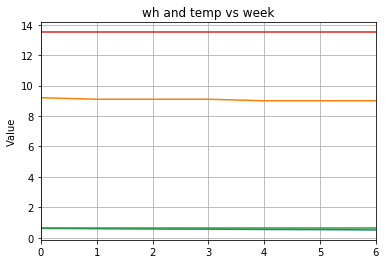

In [279]:
plt.title('wh and temp vs week')
plt.ylabel('Value')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
x= range(7)
plt.plot(x,actual)
plt.plot(x,pred)
plt.show()

#ok so according to this. the actual values were a bit lower for both the wh and the temperature 
